## Try 1

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Lending_club_loan_data/accepted_2007_to_2018Q4.csv'
df = pd.read_csv(file_path, low_memory=False)

df.shape, df.columns[:10]

Mounted at /content/drive


((2260701, 151),
 Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
        'term', 'int_rate', 'installment', 'grade', 'sub_grade'],
       dtype='object'))

In [2]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

df['loan_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

df['loan_default'].value_counts(normalize=True)


,proportion
loan_default,
0,0.800374
1,0.199626


In [3]:
df['loan_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

selected_features = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'emp_length', 'home_ownership', 'annual_inc',
    'purpose', 'dti', 'delinq_2yrs', 'open_acc',
    'revol_util', 'total_acc', 'issue_d', 'loan_status', 'loan_default'
]

df = df[selected_features].copy()

In [4]:
df = df.dropna(subset=['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'issue_d', 'loan_status'])

In [5]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
monthly_default_rate = (
    df.groupby(df['issue_d'].dt.to_period("M"))['loan_default']
    .mean()
    .reset_index()
)
monthly_default_rate['issue_d'] = monthly_default_rate['issue_d'].dt.to_timestamp()
monthly_default_rate.columns = ['month', 'default_rate']

monthly_default_rate.tail()

/tmp/ipython-input-5-361232429.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


,month,default_rate
134,2018-08-01,0.088633
135,2018-09-01,0.071488
136,2018-10-01,0.039609
137,2018-11-01,0.014751
138,2018-12-01,0.010442


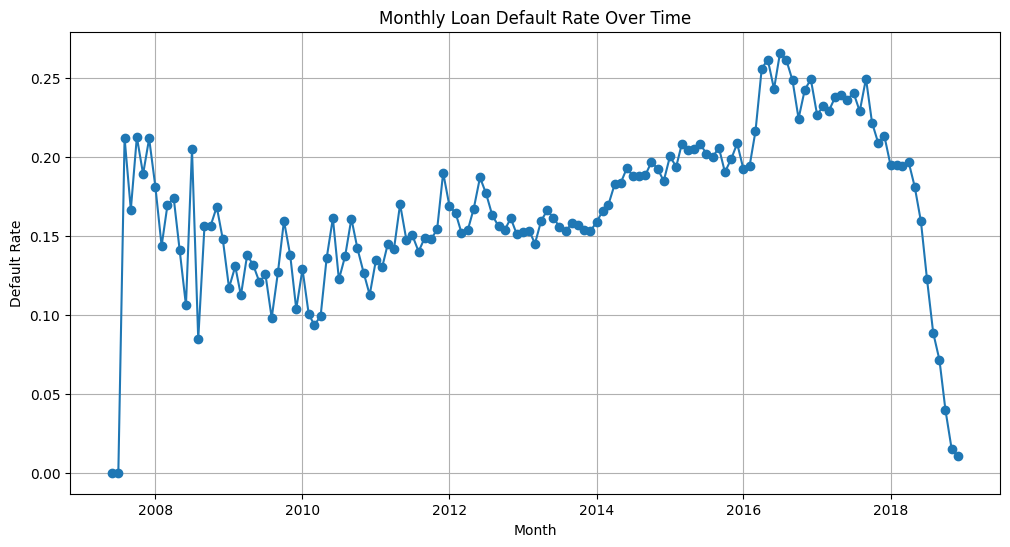

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_default_rate['month'], monthly_default_rate['default_rate'], marker='o')
plt.title('Monthly Loan Default Rate Over Time')
plt.xlabel('Month')
plt.ylabel('Default Rate')
plt.grid(True)
plt.show()

In [7]:

ts = monthly_default_rate.set_index('month')['default_rate']

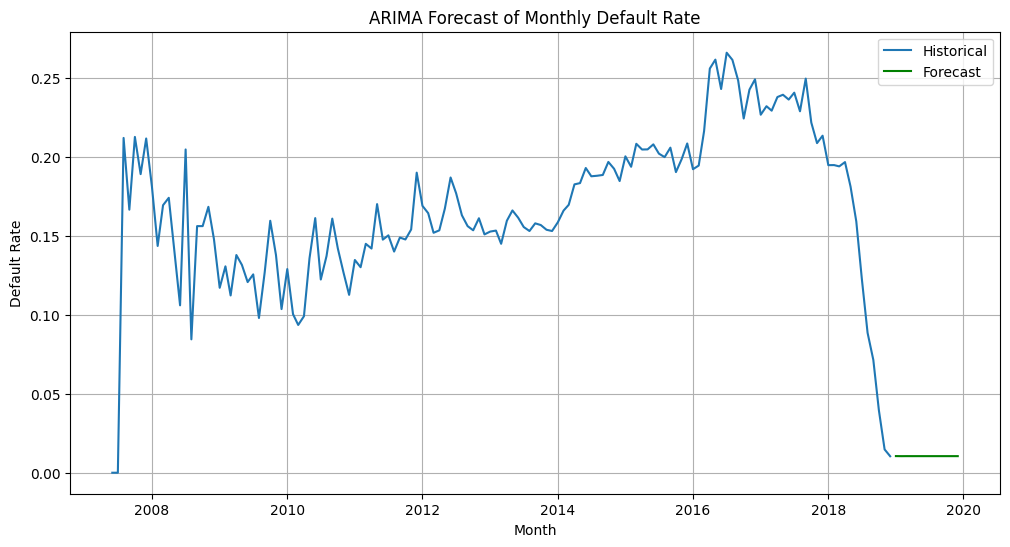

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(ts, order=(1, 1, 1))
fitted_model = model.fit()

forecast = fitted_model.forecast(steps=12)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical')
plt.plot(pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS'), forecast, label='Forecast', color='green')
plt.title('ARIMA Forecast of Monthly Default Rate')
plt.xlabel('Month')
plt.ylabel('Default Rate')
plt.legend()
plt.grid(True)
plt.show()


## LightGBM

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'purpose']
df[categorical_cols] = df[categorical_cols].astype(str)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer

X = df.drop(columns=['loan_status', 'loan_default', 'issue_d'])
y = df['loan_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[214008   1282]
 [ 52648   1050]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89    215290
           1       0.45      0.02      0.04     53698

    accuracy                           0.80    268988
   macro avg       0.63      0.51      0.46    268988
weighted avg       0.73      0.80      0.72    268988

ROC AUC Score: 0.6156465801318333


In [11]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)

y_pred_lgb = lgb_clf.predict(X_test)
y_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]

print("LightGBM Model Performance:\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_lgb))

[LightGBM] [Info] Number of positive: 214790, number of negative: 861158
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1075948, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199629 -> initscore=-1.388617
[LightGBM] [Info] Start training from score -1.388617
LightGBM Model Performance:

Confusion Matrix:
 [[212439   2851]
 [ 50057   3641]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89    215290
           1       0.56      0.07      0.12     53698

    accuracy                           0.80    268988
   macro avg       0.69      0.53      0.51    268988
weighted avg       0.76      0.80      0.74    268988

ROC

## XGBoost

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:, 1]
print("RF ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

RF ROC-AUC: 0.6940161994042542


In [13]:
!pip install xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                    scale_pos_weight= (y_train==0).sum()/ (y_train==1).sum(),
                    use_label_encoder=False, eval_metric='auc', random_state=42)

xgb.fit(X_train, y_train)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

XGBoost ROC-AUC: 0.7152259766460278


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

Confusion Matrix:
 [[131358  83932]
 [ 16843  36855]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.61      0.72    215290
           1       0.31      0.69      0.42     53698

    accuracy                           0.63    268988
   macro avg       0.60      0.65      0.57    268988
weighted avg       0.77      0.63      0.66    268988

ROC AUC Score: 0.7064943020701093


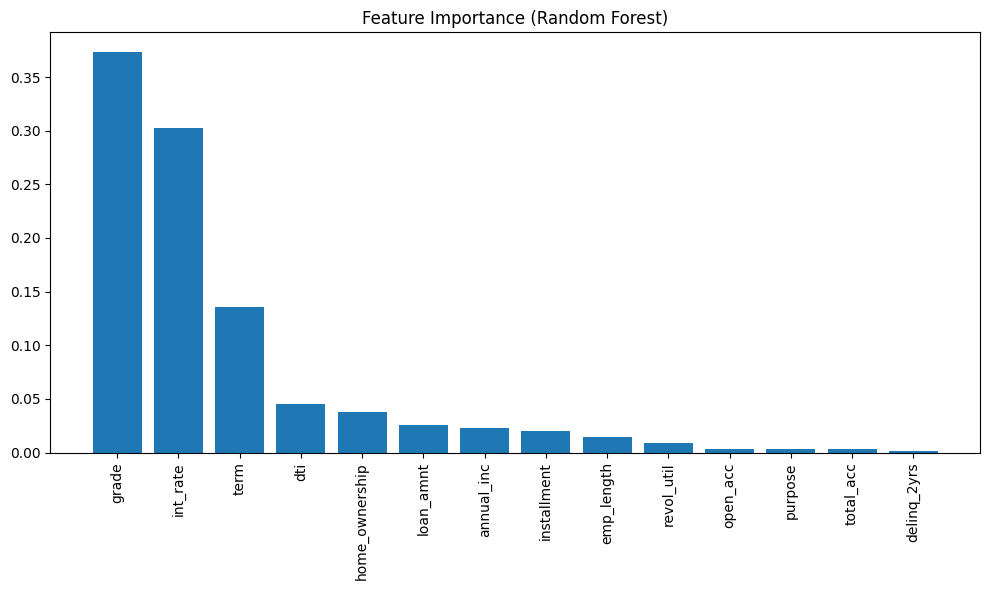

In [15]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
features = X.columns

indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## Bayesian

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X = df.drop(columns=['loan_status', 'loan_default', 'issue_d'])
y = df['loan_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [17]:
df['missed_emi'] = df['delinq_2yrs'] > 0

In [18]:
p_evidence_given_default = df[df['loan_default'] == 1]['missed_emi'].mean()

p_evidence = df['missed_emi'].mean()

print(f"P(Missed EMI | Default): {p_evidence_given_default:.2f}")
print(f"P(Missed EMI): {p_evidence:.2f}")

P(Missed EMI | Default): 0.21
P(Missed EMI): 0.19


In [19]:
def bayesian_update(prior, p_evidence_given_default, p_evidence):
    if p_evidence == 0:
        return prior
    return (p_evidence_given_default * prior) / p_evidence

In [20]:
import pandas as pd

sample_data = X_test.copy()
sample_data['prior_risk'] = rf.predict_proba(X_test)[:, 1]
sample_data['missed_emi'] = sample_data['delinq_2yrs'] > 0

sample_data['updated_risk'] = sample_data.apply(
    lambda row: bayesian_update(row['prior_risk'], p_evidence_given_default, p_evidence)
    if row['missed_emi'] else row['prior_risk'],
    axis=1
)

sample_data[['prior_risk', 'missed_emi', 'updated_risk']].head()

,prior_risk,missed_emi,updated_risk
2009507,0.369914,True,0.397495
1729214,0.148571,False,0.148571
667494,0.539029,False,0.539029
1816304,0.380449,False,0.380449
1976253,0.502824,False,0.502824


In [21]:
cols_to_check = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs']
sample_data = X_test[cols_to_check].copy()

sample_data['prior_risk'] = rf.predict_proba(X_test)[:, 1]
sample_data['missed_emi'] = X_test['delinq_2yrs'] > 0
sample_data['updated_risk'] = sample_data.apply(
    lambda row: bayesian_update(row['prior_risk'], p_evidence_given_default, p_evidence)
    if row['missed_emi'] else row['prior_risk'], axis=1
)

sample_data_sorted = sample_data.sort_values(by='updated_risk', ascending=False)
sample_data_sorted.head(10)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,prior_risk,missed_emi,updated_risk
1052804,10800.0,28.99,30000.0,43.48,6.0,0.836883,True,0.899281
2008177,19050.0,26.49,51576.0,28.41,1.0,0.834961,True,0.897215
1286461,10200.0,25.83,34300.0,27.43,1.0,0.832485,True,0.894554
817315,20000.0,28.72,52260.0,30.29,1.0,0.832454,True,0.894521
1738110,17825.0,28.69,43620.0,27.18,2.0,0.831922,True,0.893950
1055234,15850.0,26.57,65000.0,39.31,1.0,0.830492,True,0.892414
687886,12425.0,28.88,36500.0,37.55,1.0,0.827577,True,0.889281
1070135,23900.0,23.13,52000.0,36.64,2.0,0.825381,True,0.886921
917248,35000.0,28.72,60000.0,42.00,2.0,0.824458,True,0.885929
529725,14400.0,30.89,35000.0,33.40,1.0,0.824425,True,0.885894


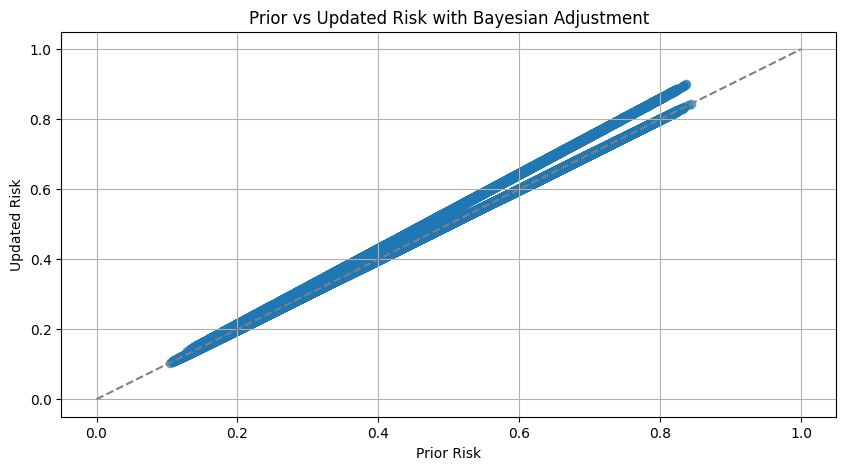

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(sample_data_sorted['prior_risk'], sample_data_sorted['updated_risk'], alpha=0.6)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Prior Risk')
plt.ylabel('Updated Risk')
plt.title('Prior vs Updated Risk with Bayesian Adjustment')
plt.grid(True)
plt.show()

In [26]:
print(X.columns.tolist())

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'delinq_2yrs', 'open_acc', 'revol_util', 'total_acc']


In [28]:
import joblib
from google.colab import files
joblib.dump(rf, "rf_model.joblib")
joblib.dump(label_encoders, "label_encoders.joblib")

files.download("rf_model.joblib")
files.download("label_encoders.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>